In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import zipfile

In [3]:
# Function to extracr 
def load_data_from_zip(zipfile_path, delimiter=","):
    with zipfile.ZipFile(zipfile_path, "r") as f:
        name = f.namelist()[0]
        with f.open(name) as zf:
            return pd.read_csv(zf, sep=delimiter)


In [4]:
train_df = load_data_from_zip("/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip", "\t")
test_df = load_data_from_zip("/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip", "\t")

In [5]:
print(train_df.shape)
print(test_df.shape)

(156060, 4)
(66292, 3)


In [6]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


Sentences are divided among phrases and each phrase has been labelled different sentiment. 

In [7]:
train_df.describe()

,PhraseId,SentenceId,Sentiment
count,156060.000000,156060.000000,156060.000000
mean,78030.500000,4079.732744,2.063578
std,45050.785842,2502.764394,0.893832
min,1.000000,1.000000,0.000000
25%,39015.750000,1861.750000,2.000000
50%,78030.500000,4017.000000,2.000000
75%,117045.250000,6244.000000,3.000000
max,156060.000000,8544.000000,4.000000


* Index of phrase is not according to the Sentence. It is unique for each row.
* Total 8544 sentences are present in the training dataset. 

Split training data set to Train and Validation set, such that phrases of one sentence are either in Validation set or in training set. 

In [57]:
train_index_list, validation_index_list = train_test_split(\
                                    np.unique(train_df['SentenceId']),\
                                    test_size=0.2, random_state=42)

validation_df = train_df[train_df['SentenceId'].isin(validation_index_list)]
train_df = train_df[train_df['SentenceId'].isin(train_index_list)]

In [56]:
train_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [58]:
print(train_df.shape)
print(validation_df.shape)

(99764, 4)
(25448, 4)


Create Model

In [61]:
class Model(tf.keras.Model):
    
    def __init__(self, embed_url):
        super().__init__()
        self.embed = hub.load(embed_url)
        self.sequential = tf.keras.Sequential([
            tf.keras.layers.Dense(256),
            tf.keras.layers.Dense(64),
            tf.keras.layers.Dense(5)
        ])
            
    def call(self, nn_input):
        phrases = nn_input['Phrase'][:,0]
        embedding = self.embed(phrases)
        return self.sequential(embedding)       

In [73]:
# Using Universal Sentence Encoder 
model = Model('https://tfhub.dev/google/universal-sentence-encoder/4')  

In [74]:
model.compile(
            loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.optimizers.Adam(),
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")]
        )

In [75]:
history = model.fit(x=dict(train_df), y=train_df['Sentiment'],
                    validation_data=(dict(validation_df), validation_df['Sentiment']),
                    epochs=25
          )

Epoch 1/25
3118/3118 [==============================] - 25s 8ms/step - loss: 0.9684 - accuracy: 0.6014 - val_loss: 0.9481 - val_accuracy: 0.6138
Epoch 2/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9490 - accuracy: 0.6084 - val_loss: 0.9582 - val_accuracy: 0.6077
Epoch 3/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9442 - accuracy: 0.6106 - val_loss: 0.9440 - val_accuracy: 0.6142
Epoch 4/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9415 - accuracy: 0.6123 - val_loss: 0.9395 - val_accuracy: 0.6174
Epoch 5/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9396 - accuracy: 0.6123 - val_loss: 0.9410 - val_accuracy: 0.6141
Epoch 6/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9376 - accuracy: 0.6147 - val_loss: 0.9399 - val_accuracy: 0.6166
Epoch 7/25
3118/3118 [==============================] - 24s 8ms/step - loss: 0.9371 - accuracy: 0.6130 - val_loss: 0.9370 - val_ac

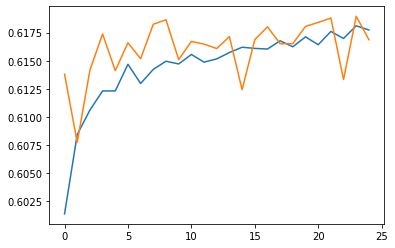

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [77]:
train_eval_result = model.evaluate(dict(train_df), train_df['Sentiment'])
validation_eval_result = model.evaluate(dict(validation_df), validation_df['Sentiment'])

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")


796/796 [==============================] - 4s 5ms/step - loss: 0.9391 - accuracy: 0.6169
Training set accuracy: 0.6197526454925537
Validation set accuracy: 0.6168657541275024


In [78]:
validation_set_predictions = model.predict(dict(validation_df))
validation_set_predictions = tf.argmax(validation_set_predictions, axis=-1)

In [79]:
cm = tf.math.confusion_matrix(validation_df['Sentiment'], validation_set_predictions)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(33.0, 0.5, 'True')

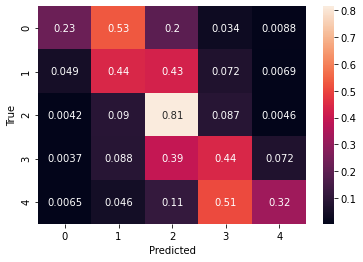

In [81]:
import seaborn as sns
sns.heatmap(
    cm, annot=True,
    xticklabels=range(5),
    yticklabels=range(5))
plt.xlabel("Predicted")
plt.ylabel("True")

In [82]:
predictions = model.predict(dict(test_df))
predictions = tf.argmax(predictions, axis=-1)

In [83]:
test_df['Sentiment'] = predictions

In [88]:
test_df[['PhraseId', 'Sentiment']].to_csv("predictions.csv", index=False)

In [86]:
test_df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,3
1,156062,8545,An intermittently pleasing but mostly routine ...,3
2,156063,8545,An,2
3,156064,8545,intermittently pleasing but mostly routine effort,3
4,156065,8545,intermittently pleasing but mostly routine,3
